# Task
Our task is simple, recognize handwritten digits. We will use MNIST dataset for this tutorial.


# Import necessary library
In this tutorial, we are going to use pytorch, the cutting-edge deep learning framework to complete our task.

In [1]:
import torch
import torchvision

In [2]:
## Create dataloader, in PyTorch, we feed the trainer data with use of dataloader
## We create dataloader with dataset from torchvision, 
## and we dont have to download it seperately, all automatically done

# Define batch size, batch size is how much data you feed for training in one iteration
batch_size_train = 64 # We use a small batch size here for training
batch_size_test = 1024 #

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
#image datasets
train_dataset = torchvision.datasets.MNIST('dataset/', 
                                           train=True, 
                                           download=True,
                                           transform=image_transform)
test_dataset = torchvision.datasets.MNIST('dataset/', 
                                          train=False, 
                                          download=True,
                                          transform=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True)

In [137]:
import numpy as np

# print(example_datas)
# print(example_datas.shape)
print(example_datas[-2:-1])
print(example_datas[-2:-1].shape)

tensor([[[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.424

Label: tensor(2)


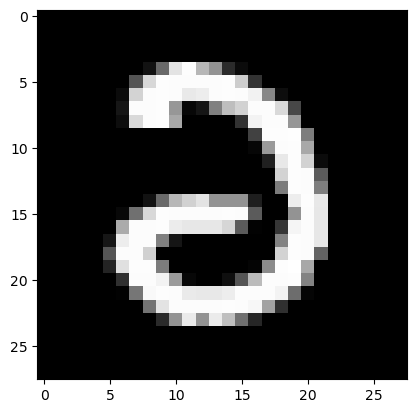

In [3]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(test_loader))
sample = example_datas[0][0]
# show the data
plt.imshow(sample, cmap='gray', interpolation='none')
print("Label: "+ str(labels[0]))

In [4]:
## Now we can start to build our CNN model
## We first import the pytorch nn module and optimizer
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
## Then define the model class
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #input channel 1, output channel 10
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1)
        #input channel 10, output channel 20
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1)
        #dropout layer
        self.conv2_drop = nn.Dropout2d()
        #fully connected layer
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.view(-1, 320)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x)

In [5]:
## create model and optimizer
learning_rate = 0.01
momentum = 0.5
device = "cpu"
model = CNN().to(device) #using cpu here
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

In [6]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer, epoch, log_interval=10000):
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    counter = 0
    for batch_idx, (data, target) in enumerate(tk0):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        counter += 1
        tk0.set_postfix(loss=(loss.item()*data.size(0) / (counter * train_loader.batch_size)))
##define test function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [7]:
num_epoch = 7
for epoch in range(1, num_epoch + 1):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)

/tmp/ipykernel_1184/1895196525.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk0 = tqdm(train_loader, total=int(len(train_loader)))


  0%|          | 0/938 [00:00<?, ?it/s]

/tmp/ipykernel_1184/4020281764.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Average loss: 0.3021, Accuracy: 9133/10000 (91%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1934, Accuracy: 9437/10000 (94%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1605, Accuracy: 9505/10000 (95%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1326, Accuracy: 9615/10000 (96%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1266, Accuracy: 9632/10000 (96%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1152, Accuracy: 9672/10000 (97%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1030, Accuracy: 9689/10000 (97%)



In [8]:
# from torchsummary import summary
# summary(model, (1, 28, 28))

# more than simple inference

In [143]:
test_dataset = torchvision.datasets.MNIST('dataset/', 
                                          train=False, 
                                          download=True,
                                          transform=None)
test_dataset[0][0].show()

In [146]:
another_inf_data = image_transform(test_dataset[0][0])
print(another_inf_data.shape)

model.eval()
another_output = model(another_inf_data)

print(another_output.argmax(dim=1))
print(another_output.shape)

torch.Size([1, 28, 28])
tensor([7])
torch.Size([1, 10])


/tmp/ipykernel_1184/4020281764.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


# simple inference

In [141]:
# import torchvision.transforms as transforms
# from PIL import Image

# to_pil = transforms.ToPILImage()
inf_data = example_datas[0]
print(f"input shape {inf_data.shape}")

model.eval()
inf_output = model(inf_data)

print(f"output shape {inf_output.shape}")

print(inf_output.argmax(dim=1))
print(inf_output.argmax(dim=1)[0])

input shape torch.Size([1, 28, 28])
output shape torch.Size([1, 10])
tensor([2])
tensor(2)


/opt/conda/lib/python3.11/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(
/tmp/ipykernel_1184/4020281764.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


# model save

In [105]:
model_version = 'v3'

In [106]:
model_name = 'mnist_torch'

In [107]:
mnist_pbtxt='''
name: "mnist"
platform: "pytorch_libtorch"
max_batch_size: 1
input [
  {
    name: "INPUT__0"
    data_type: TYPE_FP32
    dims: [-1,1,28,28]
  }
]
output [
  {
    name: "OUTPUT__0"
    data_type: TYPE_FP32
    dims: [-1,10]
  }
]

instance_group [
    {
        count: 1
        kind: KIND_CPU
    }
]
'''

In [108]:
# dummy torch save model
import os
p = f"./models/{model_name}/{model_version}"
os.makedirs(p, exist_ok=True)
torch.save(model, os.path.join(p, "dummy_model.pt"))

In [109]:
with open(f"./models/{model_name}/config.pbtxt", "w") as f:
    f.write(mnist_pbtxt)

# idempotent register (register + upload)

In [110]:
# TODO: modify to upload the whole folder
from minio import Minio
from model_registry import ModelRegistry
from typing import Any
import os

In [111]:
STORAGE_URL = "minio-service.kubeflow.svc.cluster.local:9000"
ACCESS_KEY = "minio"  # I am lazy
SECRET_KEY = "minio123" # I am lazy

MODEL_REGISTRY_URL = "http://model-registry-service.kubeflow-user-example-com.svc.cluster.local"
MODEL_REGISTRY_PORT = 8080

In [112]:
minio_client = Minio(STORAGE_URL,
    access_key=ACCESS_KEY,
    secret_key=SECRET_KEY,
    secure=False  # only when you use http
)

In [113]:
registry = ModelRegistry(
    server_address=MODEL_REGISTRY_URL,
    port=MODEL_REGISTRY_PORT,
    author="joel",
    is_secure=False  # Set to True if your Model Registry uses HTTPS
)

In [114]:
def upload(client, source, bucket_name='models') -> (str, str):
    # return (bucket, object string) if successful
    # upload file into bucket
    source_file = source

    found = client.bucket_exists(bucket_name)
    if not found:
        client.make_bucket(bucket_name)
        print('Created bucket', bucket_name)
    else:
        print('Bucket', bucket_name, 'already exists')

    storage_model_folder = source.split(os.sep)[-1]
    for root, _, files in os.walk(source):
        for file_name in files:
            local_file_path = os.path.join(root, file_name)
            relative_path = os.path.relpath(local_file_path, source)
            storage_key = os.path.join(storage_model_folder, relative_path).replace(os.sep, "/")
            # keep the same path in local and in storage
            client.fput_object(bucket_name, storage_key, local_file_path)
            print(relative_path, 'successfully uploaded as object', storage_key, 'to bucket', bucket_name)
            
    return bucket_name, f"{bucket_name}/{source.split(os.sep)[-1]}"
    

In [115]:
# upload(minio_client, './models/mnist_torch')

In [116]:
def register(registry, name, path, version, **kwargs) -> Any:
    registry.register_model(name, path, model_format_name=kwargs.get('model_format_name', 'pytorch'), model_format_version=kwargs.get('model_format_version', '1'), version=version, description=kwargs.get('description', None), metadata=kwargs.get('metadata'))
    return registry

In [117]:
# register(registry, model_name, 'models/mnist_torch', 'v2')

In [118]:
def upload_reg(client, source, registry, name, version, **kwargs) -> Any:
    # if success return registry

    bucket_name='models'
    destination = None
    try:
        bucket_name, destination = upload(client, source, bucket_name=bucket_name)
    except Exception as e:
        try:
            client.remove_object(bucket_name, destination)
        except:
            print('Unexpected error in upload and remove')
        finally:
            print('Unexpected error in upload')
            return

    try:
        print(destination)
        return register(registry, name, f'{STORAGE_URL}/{destination}', version, **kwargs)
    except:
        print('Unexpected error in register')
        return
            

In [119]:
# upload(minio_client, './models/dummy_model.pt', 'pytorch/dummy_model.pt', bucket_name='models')

In [120]:
reg = upload_reg(minio_client, './models/mnist_torch', registry, model_name, model_version)

Bucket models already exists
config.pbtxt successfully uploaded as object mnist_torch/config.pbtxt to bucket models
v3/dummy_model.pt successfully uploaded as object mnist_torch/v3/dummy_model.pt to bucket models
v1-test2/dummy_model.pt successfully uploaded as object mnist_torch/v1-test2/dummy_model.pt to bucket models
v1-test/dummy_model.pt successfully uploaded as object mnist_torch/v1-test/dummy_model.pt to bucket models
v1-test1/dummy_model.pt successfully uploaded as object mnist_torch/v1-test1/dummy_model.pt to bucket models
models/mnist_torch


# examine the artifactory

In [122]:
art = reg.get_model_artifact("mnist_torch", "v3")
print("Registered Artifact:", art, "with ID", art.id)

Registered Artifact: name='mnist_torch' id='6' description=None external_id=None create_time_since_epoch='1762992616726' last_update_time_since_epoch='1762992616726' custom_properties=None state=<ArtifactState.UNKNOWN: 'UNKNOWN'> experiment_id=None experiment_run_id=None model_format_name='pytorch' model_format_version='1' storage_key=None storage_path=None service_account_name=None model_source_kind=None model_source_class=None model_source_group=None model_source_id=None model_source_name=None uri='minio-service.kubeflow.svc.cluster.local:9000/models/mnist_torch' with ID 6
